# Frequency Response Simulation and Analysis

In [1]:
using Pkg
Pkg.activate(dirname(@__DIR__))

  Activating environment at `~/MitoChannelAnalysis/FrequencyResponse/Project.toml`


In [2]:
Pkg.status()

     Project FrequencyResponse v0.1.0
      Status `~/MitoChannelAnalysis/FrequencyResponse/Project.toml`
  [479239e8] Catalyst v6.3.1
  [717857b8] DSP v0.6.10
  [31a5f54b] Debugger v0.6.7
  [0c46a032] DifferentialEquations v6.16.0
  [5ce5e58b] FindSteadyStates v0.1.1
  [41a02a25] Folds v0.2.1
  [f6369f11] ForwardDiff v0.10.16
  [7f56f5a3] LSODA v0.6.2
  [b964fa9f] LaTeXStrings v1.2.0
  [961ee093] ModelingToolkit v4.5.0
  [0db19996] NBInclude v2.2.0
  [c030b06c] ODE v2.12.0
  [429524aa] Optim v1.2.4
  [d96e819e] Parameters v0.12.2
  [91a5bcdd] Plots v1.10.5
  [49802e3a] ProgressBars v1.0.0
  [d330b81b] PyPlot v2.9.0
  [189a3867] Reexport v1.0.0
  [413adb04] RetroSignalModel v0.2.0 `https://github.com/stevengogogo/RetroSignalModel.jl#master`
  [295af30f] Revise v3.1.12
  [ebc72ef8] SciPy v0.1.0
  [2913bbd2] StatsBase v0.33.3
  [c3572dad] Sundials v4.4.1
  [10745b16] Statistics
  [8dfed614] Test


In [3]:
using FrequencyResponse
using RetroSignalModel
using DifferentialEquations
using LaTeXStrings
using ProgressBars
using DSP
import PyPlot
import Folds
const plt = PyPlot;

In [4]:
function show_all(sol)
        prl = Dict(
        :name=> [:bmhmks, :Rtg1_n, :Rtg3_n, :Rtg13_n],
        :label=> [string("Output\n",i)   for i in ["Bmh/Mksp (nM)", "Nucleus Rtg1p (nM)", "Nucleus Rtg3p (nM)", "Nucleus Rtg1/3p (nM)"]  ]
    )
    
    figs, axes = [], []
    
    for (n,l) in zip(prl[:name], prl[:label])
        fig_,ax_ = plotSol(sol, n, dynmodel; ylabel_output= l)
        push!(figs, fig_)
        push!(axes, ax_)
    end
    return Fig.(figs, axes,  prl[:name])
end;

function output(us, inds)
    return [ sum(u[inds]) for u in us]
end

output (generic function with 1 method)

In [5]:
pr_is = RetroSignalModel.rtgM4().protein_lookup
rtg13_n = pr_is[:Rtg13_n]
rtg3_n = pr_is[:Rtg3_n]

4-element Vector{Int64}:
 12
 13
 16
 17

## Setup

In [6]:
i_sol_PLACE_HOLDER=2
# Load Model
RTGm = RetroSignalModel.rtgM4(i_sol_PLACE_HOLDER)
param= (; u=RTGm.u, p=RTGm.p);

In [7]:
# Dynamical Signal
dynmodel = DynModel(
    model = RTGm.model,
    u = param.u,
    p = param.p,
    solver= Rosenbrock23(),
    signal_func = PosSine(ω=0.05,θ=(3/2)*π, amp=1),
    input_i = 1,
    tspan=(0.,500.),
    init_ss = true # Get steady state
);

## Sinusoidal Response

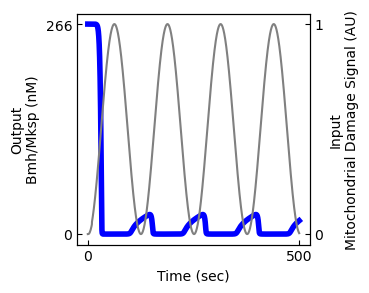

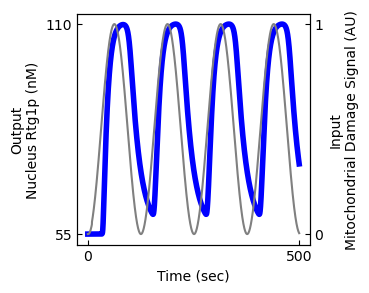

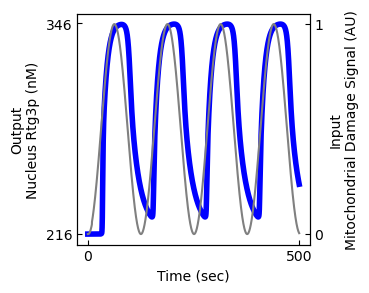

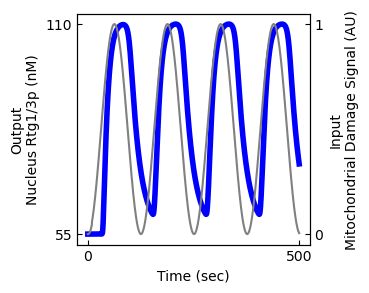

 48.488066 seconds (553.79 M allocations: 22.744 GiB, 17.12% gc time, 5.11% compilation time)


4-element Vector{Fig}:
 Fig(PyPlot.Figure(PyObject <Figure size 300x300 with 2 Axes>), nothing, :bmhmks)
 Fig(PyPlot.Figure(PyObject <Figure size 300x300 with 2 Axes>), nothing, :Rtg1_n)
 Fig(PyPlot.Figure(PyObject <Figure size 300x300 with 2 Axes>), nothing, :Rtg3_n)
 Fig(PyPlot.Figure(PyObject <Figure size 300x300 with 2 Axes>), nothing, :Rtg13_n)

In [8]:
# Solve 
@time sol = solve(dynmodel;dtmax=1., reltol=1e-15,abstol=1e-8);
figsD_sin = show_all(sol)

In [9]:
#[save.(figsD_sin, "Sine_5e-2rad", "FrequencyResponse/result/sine"; 
       # format= f) for f in ["pdf", "svg"]];

## Hysteresis

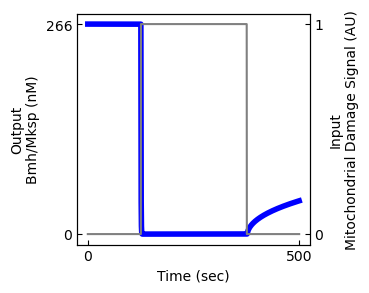

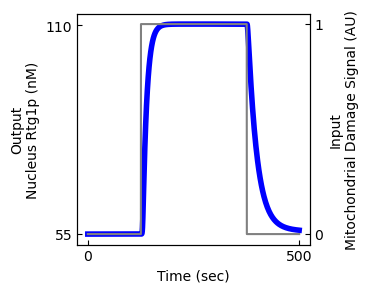

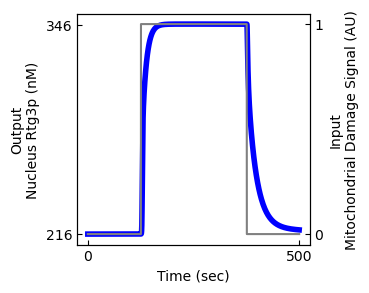

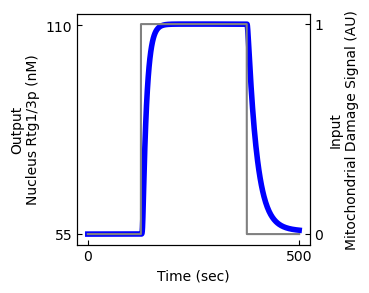

4-element Vector{Fig}:
 Fig(PyPlot.Figure(PyObject <Figure size 300x300 with 2 Axes>), nothing, :bmhmks)
 Fig(PyPlot.Figure(PyObject <Figure size 300x300 with 2 Axes>), nothing, :Rtg1_n)
 Fig(PyPlot.Figure(PyObject <Figure size 300x300 with 2 Axes>), nothing, :Rtg3_n)
 Fig(PyPlot.Figure(PyObject <Figure size 300x300 with 2 Axes>), nothing, :Rtg13_n)

In [10]:
dynmodel_sq = DynModel(dynmodel; 
                       init_ss=false, 
                       signal_func= SquarePulse(
                                    t_str = 125.,
                                    t_end = 375,
                                    amp_l =0.,
                                    amp_h = 1.) 
                        );
sol = solve(dynmodel_sq;tmax=1.);

figsD_SqPulse = show_all(sol)

In [11]:
[save.(figsD_SqPulse, "Pulse_150sec", "FrequencyResponse/result/pulse"; 
        format= f) for f in ["pdf", "svg"]];

LoadError: IOError: mkdir("FrequencyResponse/result/pulse"; mode=0o777): no such file or directory (ENOENT)

## Multiple Step Response 

- Follower
- No overshoot

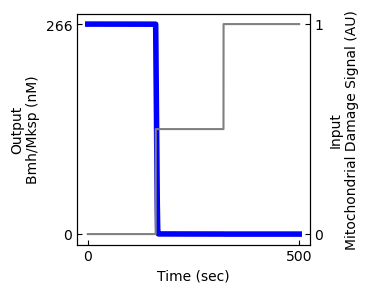

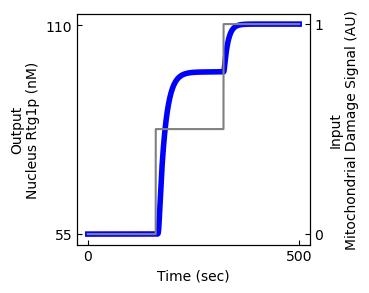

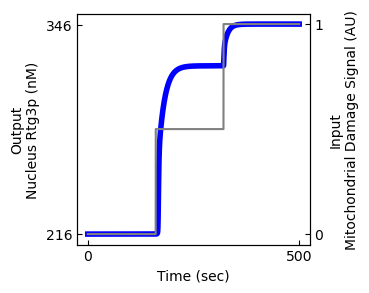

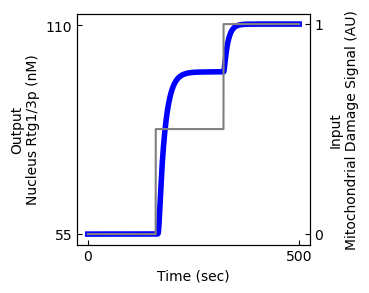

4-element Vector{Fig}:
 Fig(PyPlot.Figure(PyObject <Figure size 300x300 with 2 Axes>), nothing, :bmhmks)
 Fig(PyPlot.Figure(PyObject <Figure size 300x300 with 2 Axes>), nothing, :Rtg1_n)
 Fig(PyPlot.Figure(PyObject <Figure size 300x300 with 2 Axes>), nothing, :Rtg3_n)
 Fig(PyPlot.Figure(PyObject <Figure size 300x300 with 2 Axes>), nothing, :Rtg13_n)

In [12]:
dynmodel_sq = DynModel(dynmodel; 
                       init_ss=false, 
                       signal_func= SquarePulse(
                                    t_str = 0.,
                                    t_end = 160,
                                    amp_l =0.,
                                    amp_h = 0.)  +
                                    SquarePulse(
                                    t_str = 160.1,
                                    t_end = 320,
                                    amp_l =0,
                                    amp_h = 0.5)  +
                                    SquarePulse(
                                    t_str = 320.1,
                                    t_end = 500,
                                    amp_l =0,
                                    amp_h = 1.) 
                        );
solPulses = solve(dynmodel_sq;tmax=1.);

figsD_SqPulses = show_all(solPulses)

In [13]:
[save.(figsD_SqPulses, "Pulse_160sec320sec", "FrequencyResponse/result/pulse"; 
        format= f) for f in ["pdf", "svg"]];

LoadError: IOError: mkdir("FrequencyResponse/result/pulse"; mode=0o777): no such file or directory (ENOENT)

## Merging Pulse and Sinusoidal Response

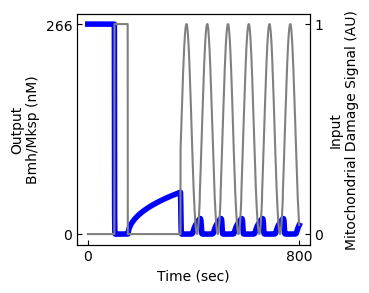

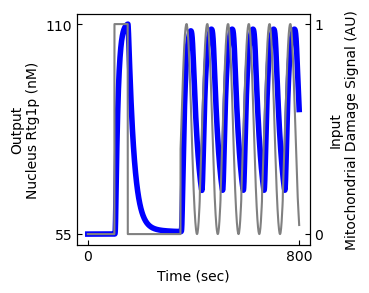

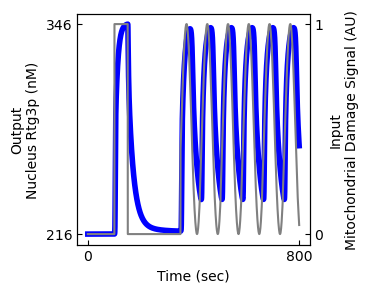

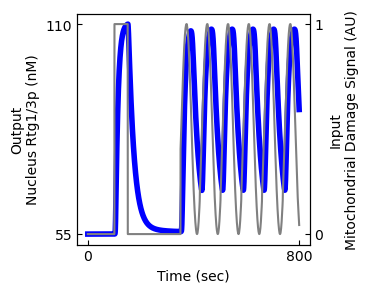

4-element Vector{Fig}:
 Fig(PyPlot.Figure(PyObject <Figure size 300x300 with 2 Axes>), nothing, :bmhmks)
 Fig(PyPlot.Figure(PyObject <Figure size 300x300 with 2 Axes>), nothing, :Rtg1_n)
 Fig(PyPlot.Figure(PyObject <Figure size 300x300 with 2 Axes>), nothing, :Rtg3_n)
 Fig(PyPlot.Figure(PyObject <Figure size 300x300 with 2 Axes>), nothing, :Rtg13_n)

In [14]:
pulse = SquarePulse(t_str = 100.,t_end = 150.,amp_l =0., amp_h = 1.) 
sigFunc = pulse + SquarePulse(pulse; t_str=350, t_end=800.) * PosSine(ω=0.08, θ=π)

dynmodel_sq = DynModel(dynmodel; 
                       init_ss=false, 
                       signal_func= sigFunc,
                        tspan=(0.,800.)
                        );
sol = solve(dynmodel_sq;tmax=0.5);

figsD_SquareSine = show_all(sol)

In [15]:
[save.(figsD_SquareSine, "SquareSine_150sec", "FrequencyResponse/result/squareSine"; format= f) for f in ["pdf", "svg"]];

LoadError: IOError: mkdir("FrequencyResponse/result/squareSine"; mode=0o777): no such file or directory (ENOENT)

## Impuse
#' 
### Short Impulse

- Short Impuse Injection (duration=1 sec)

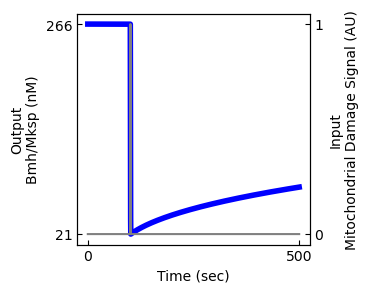

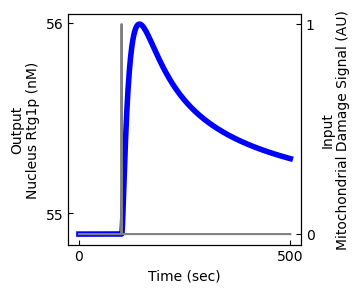

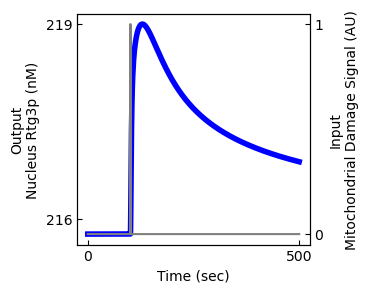

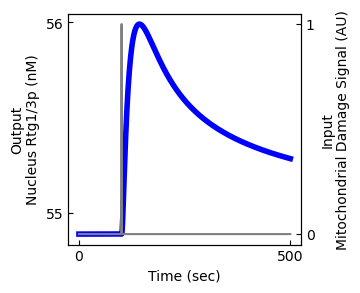

4-element Vector{Fig}:
 Fig(PyPlot.Figure(PyObject <Figure size 300x300 with 2 Axes>), nothing, :bmhmks)
 Fig(PyPlot.Figure(PyObject <Figure size 300x300 with 2 Axes>), nothing, :Rtg1_n)
 Fig(PyPlot.Figure(PyObject <Figure size 300x300 with 2 Axes>), nothing, :Rtg3_n)
 Fig(PyPlot.Figure(PyObject <Figure size 300x300 with 2 Axes>), nothing, :Rtg13_n)

In [16]:
dynmodel_sq = DynModel(dynmodel; 
                       init_ss=false, 
                       signal_func= SquarePulse(t_str = 100.,t_end = 101,amp_l =0., amp_h = 1.) ,
                        tspan=(0.,500.)
                        );
sol = solve(dynmodel_sq;tmax=0.5);

figsD_PulseShort = show_all(sol)

In [17]:
[save.(figsD_PulseShort, "Impulse_1ec", "FrequencyResponse/result/Impulse"; 
format= f) for f in ["pdf", "svg"]];

LoadError: IOError: mkdir("FrequencyResponse/result/Impulse"; mode=0o777): no such file or directory (ENOENT)

In [18]:
dynmodel_sq = DynModel(dynmodel; 
                       init_ss=false, 
                       signal_func= SquarePulse(t_str = 100.,t_end = 120,amp_l =0., amp_h = 1.) ,
                        tspan=(0.,500.)
                        );
sol = solve(dynmodel_sq;tmax=0.2);

figsD_PulseLong = show_all(sol);

[save.(figsD_PulseLong, "Impulse_20ec", "FrequencyResponse/result/Impulse"; 
format= f) for f in ["pdf", "svg"]];

LoadError: IOError: mkdir("FrequencyResponse/result/Impulse"; mode=0o777): no such file or directory (ENOENT)

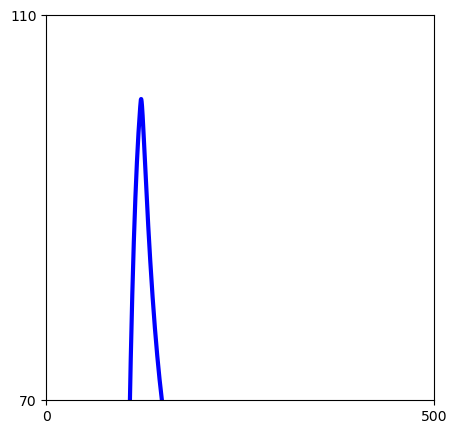

2-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.axis.YTick object at 0x7fd6ce116e20>
 PyObject <matplotlib.axis.YTick object at 0x7fd6ce1166a0>

In [19]:
fig_, ax_ = plt.subplots(figsize=(5,5))
pr = pr_is
ax_.plot(sol.t, [sum(u[pr[:Rtg13_n]]) for u in sol.u], linewidth=3, color="blue")
ax_.xaxis.set_ticks([0,500])
ax_.set_xlim([0,500])
ax_.set_ylim([70,110])
ax_.yaxis.set_ticks([70,110])

In [20]:
fig_.savefig("FrequencyResponse/result/synthetic_wave/output_Rtg13_n.pdf", box_inches="tight")

sys:1: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "box_inches" which is no longer supported as of 3.3 and will become an error two minor releases later


LoadError: PyError ($(Expr(:escape, :(ccall(#= /home/ubuntu/.julia/packages/PyCall/BD546/src/pyfncall.jl:43 =# @pysym(:PyObject_Call), PyPtr, (PyPtr, PyPtr, PyPtr), o, pyargsptr, kw))))) <class 'FileNotFoundError'>
FileNotFoundError(2, 'No such file or directory')
  File "/home/ubuntu/.julia/conda/3/lib/python3.9/site-packages/matplotlib/figure.py", line 3005, in savefig
    self.canvas.print_figure(fname, **kwargs)
  File "/home/ubuntu/.julia/conda/3/lib/python3.9/site-packages/matplotlib/backend_bases.py", line 2255, in print_figure
    result = print_method(
  File "/home/ubuntu/.julia/conda/3/lib/python3.9/site-packages/matplotlib/backend_bases.py", line 1669, in wrapper
    return func(*args, **kwargs)
  File "/home/ubuntu/.julia/conda/3/lib/python3.9/site-packages/matplotlib/_api/deprecation.py", line 431, in wrapper
    return func(*inner_args, **inner_kwargs)
  File "/home/ubuntu/.julia/conda/3/lib/python3.9/site-packages/matplotlib/backends/backend_pdf.py", line 2718, in print_pdf
    file = PdfFile(filename, metadata=metadata)
  File "/home/ubuntu/.julia/conda/3/lib/python3.9/site-packages/matplotlib/backends/backend_pdf.py", line 637, in __init__
    fh, opened = cbook.to_filehandle(filename, "wb", return_opened=True)
  File "/home/ubuntu/.julia/conda/3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py", line 462, in to_filehandle
    fh = open(fname, flag, encoding=encoding)


In [21]:
plt.rc("font", size="20")
function plotwave(ax, t, func;linewidth=1, linecolor="black")
    ydata = func.(t)
    ax.plot(t, ydata, linewidth=linewidth, color=linecolor)
    ax.set_xticks([minimum(t), maximum(t)])
    ax.set_yticks([minimum(ydata), maximum(ydata)])
    return ax
end

fig1,ax1=plt.subplots(figsize=(5,5))
fig2,ax2=plt.subplots(figsize=(5,5))
plotwave.([ax1,ax2], [0:0.1:500], [p1,p2])


ax1.set_xlim([0,250])
ax1.xaxis.set_ticks([0, 250])
ax2.set_xlim([0,250])
ax2.xaxis.set_ticks([0, 250])

#[a.set_xlabel("Time (seconds)") for a in [ax1,ax2]]
#[a.set_ylabel("Mitochondrial Damage (AU)") for a in [ax1,ax2]]

LoadError: UndefVarError: p1 not defined

In [22]:
fig1.savefig("FrequencyResponse/result/synthetic_wave/sine_low_freq.pdf")
fig2.savefig("FrequencyResponse/result/synthetic_wave/sine_high_freq.pdf")

LoadError: PyError ($(Expr(:escape, :(ccall(#= /home/ubuntu/.julia/packages/PyCall/BD546/src/pyfncall.jl:43 =# @pysym(:PyObject_Call), PyPtr, (PyPtr, PyPtr, PyPtr), o, pyargsptr, kw))))) <class 'FileNotFoundError'>
FileNotFoundError(2, 'No such file or directory')
  File "/home/ubuntu/.julia/conda/3/lib/python3.9/site-packages/matplotlib/figure.py", line 3005, in savefig
    self.canvas.print_figure(fname, **kwargs)
  File "/home/ubuntu/.julia/conda/3/lib/python3.9/site-packages/matplotlib/backend_bases.py", line 2255, in print_figure
    result = print_method(
  File "/home/ubuntu/.julia/conda/3/lib/python3.9/site-packages/matplotlib/backend_bases.py", line 1669, in wrapper
    return func(*args, **kwargs)
  File "/home/ubuntu/.julia/conda/3/lib/python3.9/site-packages/matplotlib/_api/deprecation.py", line 431, in wrapper
    return func(*inner_args, **inner_kwargs)
  File "/home/ubuntu/.julia/conda/3/lib/python3.9/site-packages/matplotlib/backends/backend_pdf.py", line 2718, in print_pdf
    file = PdfFile(filename, metadata=metadata)
  File "/home/ubuntu/.julia/conda/3/lib/python3.9/site-packages/matplotlib/backends/backend_pdf.py", line 637, in __init__
    fh, opened = cbook.to_filehandle(filename, "wb", return_opened=True)
  File "/home/ubuntu/.julia/conda/3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py", line 462, in to_filehandle
    fh = open(fname, flag, encoding=encoding)


In [23]:
p12 = p1 + p2
fig_2, ax_2 = plt.subplots(figsize=(5,5))
ax_2.plot(sol.t, [ p12(t) for t in sol.t], linewidth=1, color="black" )
ax_2.set_xlim([0,500])
ax_2.xaxis.set_ticks([0,500])
ax_2.yaxis.set_ticks([0,1])

LoadError: UndefVarError: p1 not defined

In [24]:
fig_2.savefig("FrequencyResponse/result/synthetic_wave/input.pdf", box_inches="tight")

LoadError: UndefVarError: fig_2 not defined

In [25]:
fig_, ax_ = plt.subplots(figsize=(5,5))
pr = pr_is
ax_.plot(sol.t, [sum(u[pr[:Rtg13_n]]) for u in sol.u], linewidth=3, color="blue")
ax_.xaxis.set_ticks([0,500])
ax_.set_xlim([0,500])
ax_.set_ylim([70,110])
ax_.yaxis.set_ticks([70,110])

fig_.savefig("FrequencyResponse/result/synthetic_wave/output_Rtg13_n.pdf", box_inches="tight")

sys:1: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "box_inches" which is no longer supported as of 3.3 and will become an error two minor releases later


LoadError: PyError ($(Expr(:escape, :(ccall(#= /home/ubuntu/.julia/packages/PyCall/BD546/src/pyfncall.jl:43 =# @pysym(:PyObject_Call), PyPtr, (PyPtr, PyPtr, PyPtr), o, pyargsptr, kw))))) <class 'FileNotFoundError'>
FileNotFoundError(2, 'No such file or directory')
  File "/home/ubuntu/.julia/conda/3/lib/python3.9/site-packages/matplotlib/figure.py", line 3005, in savefig
    self.canvas.print_figure(fname, **kwargs)
  File "/home/ubuntu/.julia/conda/3/lib/python3.9/site-packages/matplotlib/backend_bases.py", line 2255, in print_figure
    result = print_method(
  File "/home/ubuntu/.julia/conda/3/lib/python3.9/site-packages/matplotlib/backend_bases.py", line 1669, in wrapper
    return func(*args, **kwargs)
  File "/home/ubuntu/.julia/conda/3/lib/python3.9/site-packages/matplotlib/_api/deprecation.py", line 431, in wrapper
    return func(*inner_args, **inner_kwargs)
  File "/home/ubuntu/.julia/conda/3/lib/python3.9/site-packages/matplotlib/backends/backend_pdf.py", line 2718, in print_pdf
    file = PdfFile(filename, metadata=metadata)
  File "/home/ubuntu/.julia/conda/3/lib/python3.9/site-packages/matplotlib/backends/backend_pdf.py", line 637, in __init__
    fh, opened = cbook.to_filehandle(filename, "wb", return_opened=True)
  File "/home/ubuntu/.julia/conda/3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py", line 462, in to_filehandle
    fh = open(fname, flag, encoding=encoding)


In [26]:
p12 = p1 + p2
fig_2, ax_2 = plt.subplots(figsize=(5,5))
ax_2.plot(sol.t, [ p12(t) for t in sol.t], linewidth=1, color="black" )
ax_2.set_xlim([0,500])
ax_2.xaxis.set_ticks([0,500])
ax_2.yaxis.set_ticks([0,1])

fig_2.savefig("FrequencyResponse/result/synthetic_wave/input.pdf", box_inches="tight")

LoadError: UndefVarError: p1 not defined

## Plotting for Graphical Abstact

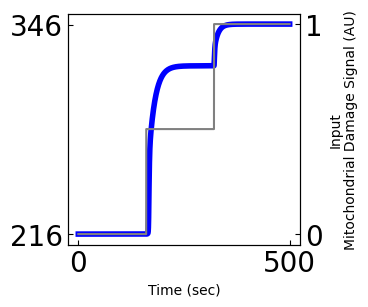

(PyPlot.Figure(PyObject <Figure size 300x300 with 2 Axes>), nothing)

In [27]:
plotSol(solPulses, :Rtg3_n, dynmodel_sq;)

### Increasing frequency of sine wave

In [28]:
function SINEV(t; t_start=0., t_end=600., ω_str=0.02, ω_end=0.7, amp=1.0, ϕ=π /2*3)
    ω_c = ω_str + (ω_end - ω_str)* (t-t_start)/(t_end-t_start)
    
    SIGNAL = 0.5*amp + 0.5*amp*sin(ω_c*t + ϕ)
    return SIGNAL
end


dynmodel_freq = DynModel(dynmodel; 
                       init_ss=false, 
                       tspan=(0.,600.),
                       signal_func= SINEV
                        );

sol = solve(dynmodel_freq;tmax=0.1);

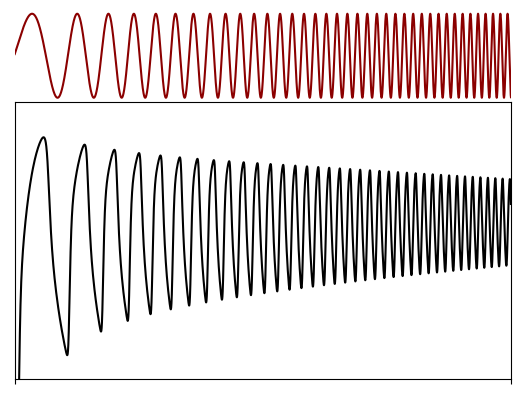

Fig(PyPlot.Figure(PyObject <Figure size 640x480 with 2 Axes>), PyCall.PyObject[PyObject <AxesSubplot:>, PyObject <AxesSubplot:>], "Freq_low_high")

In [29]:
## Plotting
out = get_sum(sol,:Rtg3_n, dynmodel_freq)
input = get_sum(sol,:s, dynmodel_freq)




fig,ax = plt.subplots(2,1; gridspec_kw= Dict(:height_ratios=> [1, 3]))

ax[1].plot(0:0.1:600, SINEV.(0:0.1:600); color="darkred", linewidth=1.5) # Input
ax[2].plot(sol.t, out;color="black", linewidth=1.5) #Output 


# Axis
ax[1].axis("off")

ax[2].yaxis.set_ticks([])
ax[2].xaxis.set_ticks([30, 450])

ax[2].set_xticklabels(["",""])
ax[2].set_xlim(30,450)
ax[1].set_xlim(30,450)
ax[2].set_ylim(250,350)


#ax[2].set_ylabel("Output", fontsize="20")
#ax[2].set_xlabel("Time", fontsize="20")




fig.subplots_adjust(
    hspace=0.
)

f = Fig(fig, ax, "Freq_low_high")

In [30]:
[save(f,"FreqVariant", "FrequencyResponse/result/GraphicalAbstract";format=i) for i in ["pdf", "svg"]]

LoadError: IOError: mkdir("FrequencyResponse/result/GraphicalAbstract"; mode=0o777): no such file or directory (ENOENT)

## Bode Plot
#' 
### Amplitude Estimation

In [31]:
function gain(ω, dynmodel)
    sig = PosSine(ω=ω)
    tspan = (-100.,500. * 0.1 / ω)
    dynmodel_ = DynModel(dynmodel; 
                           tspan=tspan,
                           init_ss=false, 
                           signal_func= sig
                            );

    sol = solve(dynmodel_;tmax=1.);
    
    out = get_sum(sol,:Rtg3_n, dynmodel_)
    input_sig = sig.(sol.t)
    
    t0_tick = findfirst(x->x>=0, sol.t)
    maxO= maximum(out[t0_tick:end])
    minO = minimum(out[t0_tick:end])
    
    maxI = maximum(input_sig[t0_tick:end])
    minI = minimum(input_sig[t0_tick:end])
    
    return maxO, minO, maxI, minI,  input_sig, out,sol
    
end

gain (generic function with 1 method)

In [32]:
range(0,3;step=3)

0:3:3

0.0%┣                                            ┫ 0/5 [00:00<00:00, -20.0 it/s]
20.0%┣████████▋                                  ┫ 1/5 [00:13<Inf:Inf, 0.0 it/s]
40.0%┣██████████████████                           ┫ 2/5 [00:21<01:03, 0.0 it/s]
60.0%┣███████████████████████████                  ┫ 3/5 [00:29<00:29, 0.1 it/s]
80.0%┣████████████████████████████████████         ┫ 4/5 [00:37<00:12, 0.1 it/s]


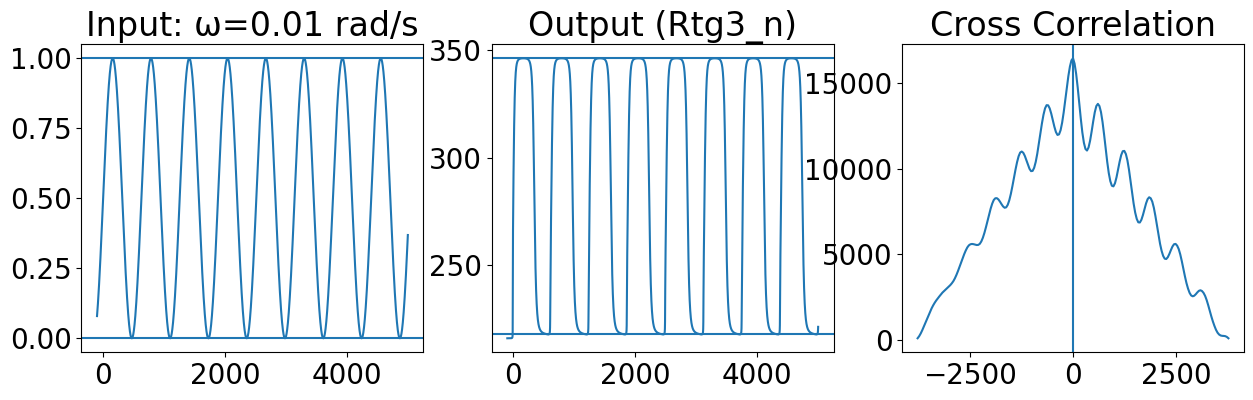

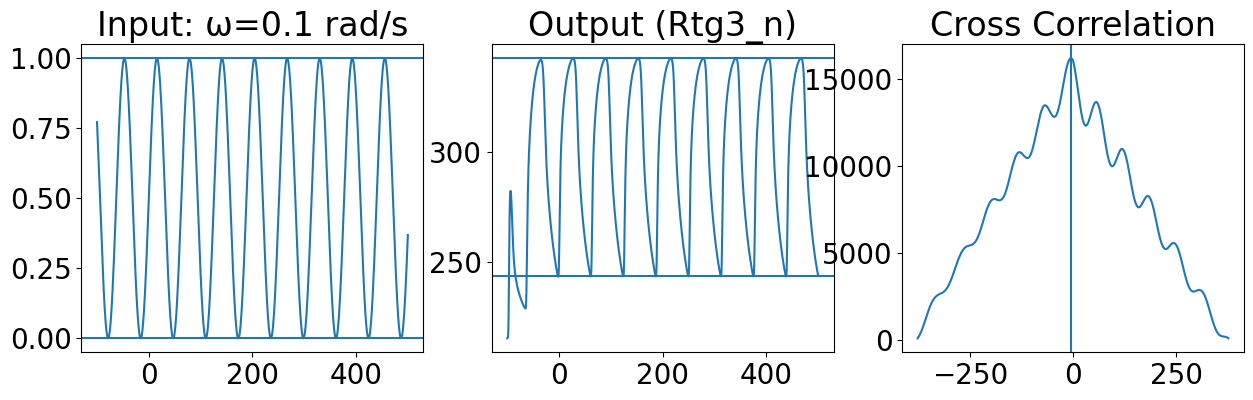

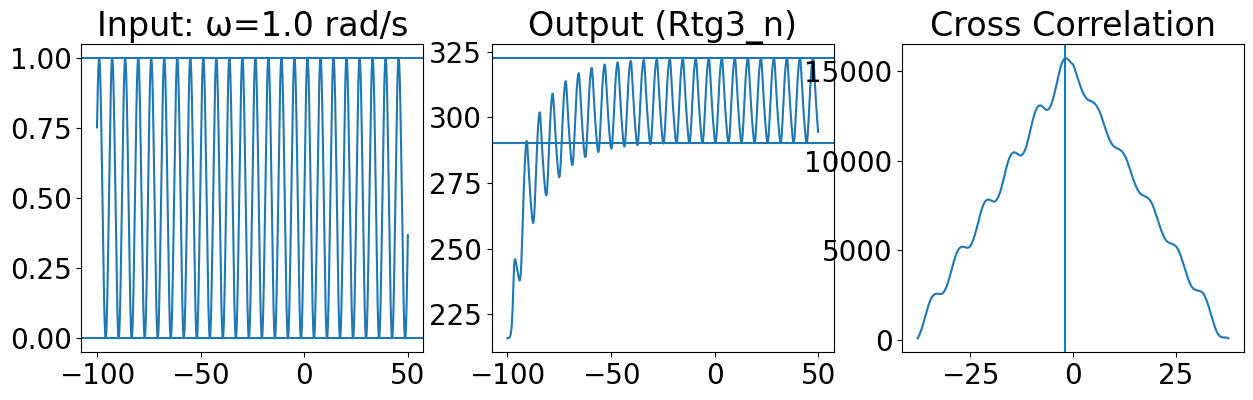

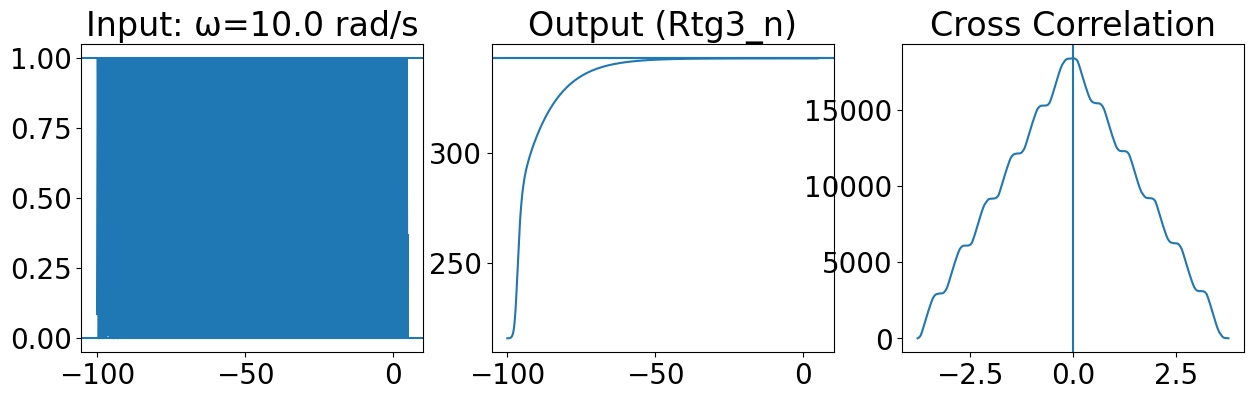

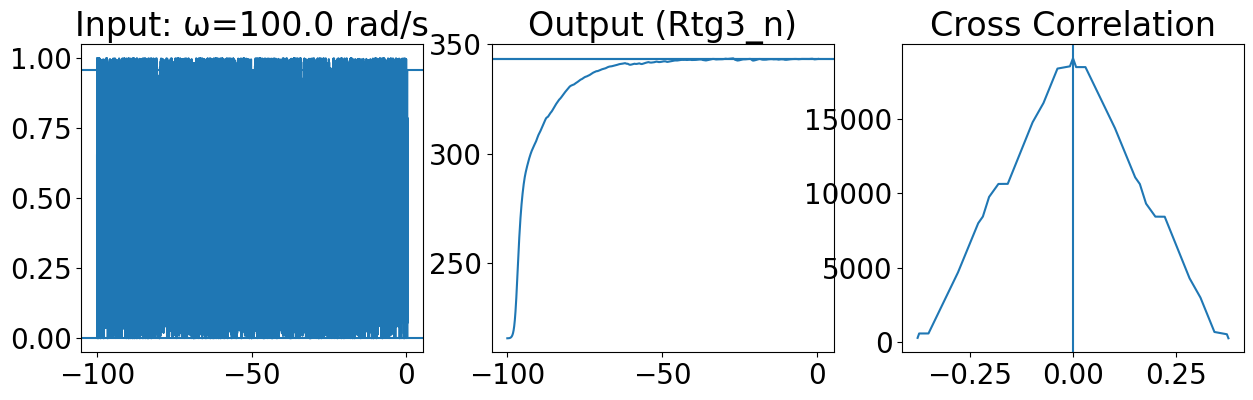

100.0%┣████████████████████████████████████████████┫ 5/5 [00:45<00:00, 0.1 it/s]
100.0%┣████████████████████████████████████████████┫ 5/5 [00:45<00:00, 0.1 it/s]



In [33]:
#[0.01, 0.1, 1, 10]
for ω in ProgressBar([0.01, 0.1, 1, 10, 100])
   
    # Gain
    maxO, minO, maxI, minI,  input_sig, out, sol = gain(ω, dynmodel)
    
    # Delay
    t_ran = (2*π/ω)*6
    tspan_ = sol.t[end] - t_ran: t_ran/100. : sol.t[end]
    

    t_shift = range(0,t_ran; length=length(tspan_) )
    
    tspan_crr = vcat(-t_shift[end:-1:2], t_shift)
   
    cross_cor = xcorr( [sol(i, idxs=1) for i in tspan_] , [ sum(sol.(i, idxs=rtg3_n)) for i in tspan_]   )
    

    
    max_t_tick = argmax(cross_cor)
    max_t = tspan_crr[max_t_tick]
    

    fig, ax = plt.subplots(1,3, figsize=(15,4))
    ax[1].plot(sol.t, input_sig)
    ax[1].axhline(maxI)
    ax[1].axhline(minI)
    ax[1].set_title("Input: ω=$(ω) rad/s")

    ax[2].plot(sol.t, out)
    ax[2].axhline(maxO)
    ax[2].axhline(minO)
    ax[2].set_title("Output (Rtg3_n)")
    
    ax[3].plot( tspan_crr ,cross_cor)
    ax[3].axvline(max_t)
    ax[3].set_title("Cross Correlation")
end

In [34]:
ωs = 10 .^(-2.:0.1:1.)

amps = zeros(length(ωs))


for i in ProgressBar(1:length(ωs))
    maxO, minO, maxI, minI,  input_sig, out, sol = gain(ωs[i], dynmodel)
    amps[i] = maxO-minO
end

0.0%┣                                           ┫ 0/31 [00:00<00:-2, -20.0 it/s]
3.2%┣█▍                                         ┫ 1/31 [00:08<Inf:Inf, 0.0 it/s]
6.5%┣███                                          ┫ 2/31 [00:16<07:34, 0.1 it/s]
9.7%┣████▍                                        ┫ 3/31 [00:23<05:22, 0.1 it/s]
12.9%┣█████▊                                      ┫ 4/31 [00:31<04:37, 0.1 it/s]
16.1%┣███████                                     ┫ 5/31 [00:39<04:10, 0.1 it/s]
19.4%┣████████▌                                   ┫ 6/31 [00:46<03:52, 0.1 it/s]
22.6%┣██████████                                  ┫ 7/31 [00:54<03:36, 0.1 it/s]
25.8%┣███████████▍                                ┫ 8/31 [01:01<03:22, 0.1 it/s]
29.0%┣████████████▊                               ┫ 9/31 [01:09<03:09, 0.1 it/s]
32.3%┣█████████████▉                             ┫ 10/31 [01:16<02:58, 0.1 it/s]
35.5%┣███████████████▎                           ┫ 11/31 [01:23<02:47, 0.1 it/s]
38.7%┣████████████████▋     

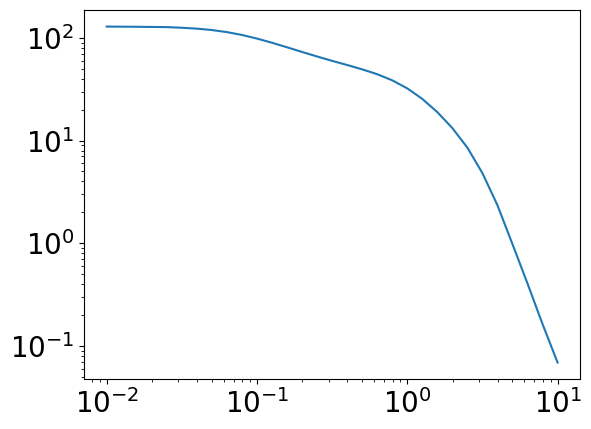

In [35]:
figg, axg = plt.subplots()
axg.plot(ωs, amps)
axg.set_yscale("log")
axg.set_xscale("log")

In [36]:
figg.savefig("FrequencyResponse/result/Bode/GainPlot.pdf";box_inches="tight", tranparent="true")

sys:1: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "box_inches" which is no longer supported as of 3.3 and will become an error two minor releases later
sys:1: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "tranparent" which is no longer supported as of 3.3 and will become an error two minor releases later


LoadError: PyError ($(Expr(:escape, :(ccall(#= /home/ubuntu/.julia/packages/PyCall/BD546/src/pyfncall.jl:43 =# @pysym(:PyObject_Call), PyPtr, (PyPtr, PyPtr, PyPtr), o, pyargsptr, kw))))) <class 'FileNotFoundError'>
FileNotFoundError(2, 'No such file or directory')
  File "/home/ubuntu/.julia/conda/3/lib/python3.9/site-packages/matplotlib/figure.py", line 3005, in savefig
    self.canvas.print_figure(fname, **kwargs)
  File "/home/ubuntu/.julia/conda/3/lib/python3.9/site-packages/matplotlib/backend_bases.py", line 2255, in print_figure
    result = print_method(
  File "/home/ubuntu/.julia/conda/3/lib/python3.9/site-packages/matplotlib/backend_bases.py", line 1669, in wrapper
    return func(*args, **kwargs)
  File "/home/ubuntu/.julia/conda/3/lib/python3.9/site-packages/matplotlib/_api/deprecation.py", line 431, in wrapper
    return func(*inner_args, **inner_kwargs)
  File "/home/ubuntu/.julia/conda/3/lib/python3.9/site-packages/matplotlib/backends/backend_pdf.py", line 2718, in print_pdf
    file = PdfFile(filename, metadata=metadata)
  File "/home/ubuntu/.julia/conda/3/lib/python3.9/site-packages/matplotlib/backends/backend_pdf.py", line 637, in __init__
    fh, opened = cbook.to_filehandle(filename, "wb", return_opened=True)
  File "/home/ubuntu/.julia/conda/3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py", line 462, in to_filehandle
    fh = open(fname, flag, encoding=encoding)


## Phase

In [37]:
maxO, minO, maxI, minI,  input_sig, out, sol = gain(0.4, dynmodel);

In [38]:
maxO, minO, maxI, minI

(330.03362300225575, 275.75967025009453, 0.9999827330917681, 0.0003242089306618734)

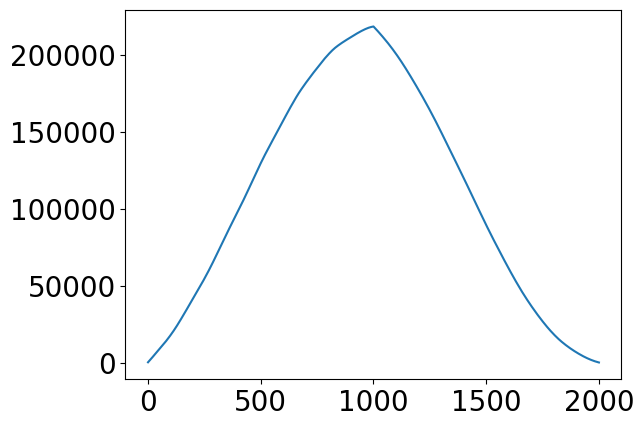

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7fd6ad2fa160>

In [39]:
plt.plot(xcorr( [sol(i, idxs=1) for i in 0:0.01:10] , [ sum(sol.(i, idxs=rtg3_n)) for i in 0:0.1:100]   ) )